<a href="https://colab.research.google.com/github/MauricioMatheus/Data-Structures-2_U2T3/blob/main/AED2_U2T3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install osmnx

In [30]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [31]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H


In [32]:
# Grafo da cidade de Natal
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [33]:
# Obter POIs de interesse - Posto de gasolina
tags = {'amenity': 'fuel'}
pois = ox.features.features_from_place(place, tags=tags)

# Extrair pontos representativos (centroides se for polígono)
gas_stations = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        gas_stations.append((row.geometry.y, row.geometry.x))
    else:
        gas_stations.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not gas_stations:
    print("Nenhum posto de gasolina encontrado. Tentando escolas...")
    tags = {'amenity': 'school'}
    pois = ox.features.features_from_place(place, tags=tags)
    for idx, row in pois.iterrows():
        if row.geometry.geom_type == 'Point':
            gas_stations.append((row.geometry.y, row.geometry.x))
        else:
            gas_stations.append((row.geometry.centroid.y, row.geometry.centroid.x))
    if not gas_stations:
        raise ValueError("Nenhum POI encontrado para as categorias tentadas.")

In [34]:
#  Encontrando os nós mais próximos dos POIs
latitudes = [hp[0] for hp in gas_stations]
longitudes = [hp[1] for hp in gas_stations]
gas_station_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
gas_station_nodes = list(set(gas_station_nodes))

if len(gas_station_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

In [35]:
len(gas_stations)

94

In [36]:
# Construindo um grafo completo com menor rota entre POIs
G_interest = nx.Graph()
for i in range(len(gas_station_nodes)):
    for j in range(i+1, len(gas_station_nodes)):
        route = nx.shortest_path(G_undirected, gas_station_nodes[i], gas_station_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(gas_station_nodes[i], gas_station_nodes[j], weight=route_length)


In [37]:
# Calculando o MST
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 75982.32997402511 metros


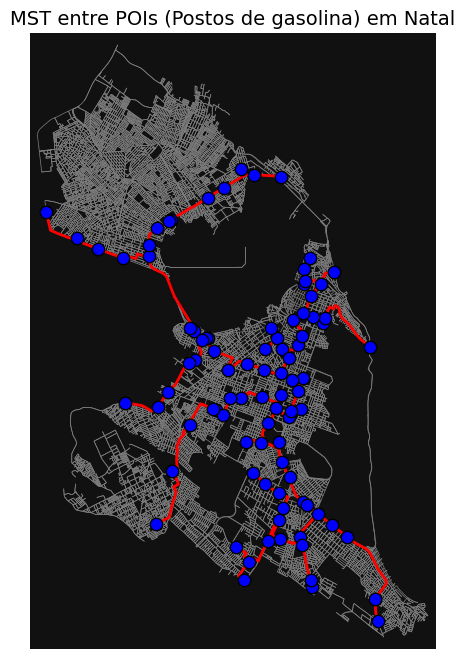

In [40]:
mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

# Plotando o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Destacando as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotando também os POIs (Postos de gasolina) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in gas_station_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in gas_station_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black')

plt.title("MST entre POIs (Postos de gasolina) em Natal", fontsize=14)
plt.show()